In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from collections import namedtuple
import seaborn as sns

In [6]:
with open('../data/tornado_pools.json') as json_file:
    tornado_addresses = json.load(json_file)

deposit_txs = pd.read_csv("../data/lighter_complete_deposit_txs.csv")
deposit_txs["tcash_pool"] = deposit_txs["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])
withdraw_txs = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
withdraw_txs["tcash_pool"] = withdraw_txs["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])

unique_deposit_addresses = set(deposit_txs["from_address"])
unique_withdraw_addresses = set(withdraw_txs["recipient_address"])

outside_tcash_txs = pd.read_csv("../data/transactions_between_deposit_and_withdraw_addresses.csv")
address_and_withdraw_df = outside_tcash_txs[["from_address", "to_address"]]

In [7]:
def filter_repeated_and_permuted(address_and_withdraw_df):
    filtered_addresses_set = set()
    
    for row in address_and_withdraw_df.itertuples():
        filtered_addresses_set.add(frozenset([row.from_address, row.to_address]))
    
    return filtered_addresses_set

def dataframe_from_set_of_sets(set_of_sets):
    addresses_df = pd.DataFrame({"address_1":[], "address_2":[]})
        
    for s in tqdm(set_of_sets):
        s_tuple = tuple(s)
        if len(s) == 2:
            addresses_df = addresses_df.append({"address_1": s_tuple[0], "address_2": s_tuple[1]}, ignore_index=True)
        else:
            addresses_df = addresses_df.append({"address_1": s_tuple[0], "address_2": s_tuple[0]}, ignore_index=True)

    return addresses_df

In [8]:
def preprocess_data(address_and_withdraw_df):
    s = filter(lambda x: len(x) == 2, filter_repeated_and_permuted(address_and_withdraw_df))
    return dataframe_from_set_of_sets(s)

In [9]:
clean_addresses = preprocess_data(address_and_withdraw_df)
clean_addresses

11230it [00:23, 471.04it/s]


,address_1,address_2
0,0xf09ff64147e5960cf9b1ff15ec7a801144be68ba,0x88db54617340c9e3aa45d2bbf1abf3f55e016686
1,0xc0c49b81f9996ae22bee60268dfc1e9787e1bb80,0x6f1bc0edd28c72bb6bb484cfbc9befa02e79a545
2,0xc5f4f273632a8cd819c4897af7227f0c8f963bf0,0xc4564956f484608f3f1f66b00858c3aaa9e4b71e
3,0x39e6bfd1371376ef25739ae21a8752290afc9a73,0x6bf9dfa346c408ed440a8d1830d26837dc34b7d4
4,0xbb612b96f29f6c418f6a8e3104fae4d5ed456ee1,0x7d67649371a34dfe8931cd07e63e6ab043d0bd22
...,...,...
11225,0x8fb26ee2e6f5a784be68c8e1a0795794a988399d,0xb0b1ac63ef2516255d86580a52df940a7b5b203a
11226,0xf01b4b37a29dc9d4079f24d11eddae4fb2efc0d4,0x5d866d0f3b3c829fac2c3b24f3800747f006aa71
11227,0x2da3d89718dffccc922c5286053bf92516d87128,0xce16ca7ff993ef64b122535627dba98090842811
11228,0x17d4febc12b039b7341a4df6a956a52d6a2b7a39,0x157b0f61c452b7f68c6485756d8472a461862a01


In [10]:
def is_D_type(address):
    return (address in unique_deposit_addresses) and (address not in unique_withdraw_addresses)

def is_W_type(address):
    return (address not in unique_deposit_addresses) and (address in unique_withdraw_addresses)

def is_DW_type(address):
    return (address in unique_deposit_addresses) and (address in unique_withdraw_addresses)

In [11]:
def is_D_W_tx(address1, address2):
    return is_D_type(address1) and is_W_type(address2)

def is_W_D_tx(address1, address2):
    return is_W_type(address1) and is_D_type(address2)

def is_D_DW_tx(address1, address2):
    return is_D_type(address1) and is_DW_type(address2)

def is_DW_D_tx(address1, address2):
    return is_DW_type(address1) and is_D_type(address2)

def is_W_DW_tx(address1, address2):
    return is_W_type(address1) and is_DW_type(address2)

def is_DW_W_tx(address1, address2):
    return is_DW_type(address1) and is_W_type(address2)

def is_DW_DW_tx(address1, address2):
    return is_DW_type(address1) and is_DW_type(address2)

In [12]:
# Map interactions between every withdraw address to every deposit address, outside TCash
def map_withdraw2deposit_interactions_outside_tcash(clean_addresses_df, unique_deposit_addresses, unique_withdraw_addresses):
    
    deposit_and_withdraw_matrix = np.empty((0, 2), dtype=str)
    
    for row in tqdm(clean_addresses_df.itertuples(), total=len(clean_addresses_df), mininterval=0.5):
                
        if is_D_W_tx(row.address_1, row.address_2) or is_D_DW_tx(row.address_1, row.address_2) or is_DW_W_tx(row.address_1, row.address_2):
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_1, row.address_2]], axis=0)
            
        elif is_W_D_tx(row.address_1, row.address_2) or is_W_DW_tx(row.address_1, row.address_2) or is_DW_D_tx(row.address_1, row.address_2):
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_2, row.address_1]], axis=0)
            
        elif is_DW_DW_tx(row.address_1, row.address_2):
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_1, row.address_2]], axis=0)
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_2, row.address_1]], axis=0)
        else:
            print(row.address_1, row.address_2)
            raise ValueError("The transaction is not from any of the types: D_W, W_D, D_DW, DW_D, W_DW, DW_W, DW_DW")

    D_W_df = pd.DataFrame(deposit_and_withdraw_matrix, columns=["deposit_address", "withdraw_address"])
    
    return dict(D_W_df.groupby("withdraw_address")["deposit_address"].apply(list))

In [13]:
waddr2daddr = map_withdraw2deposit_interactions_outside_tcash(clean_addresses, unique_deposit_addresses, unique_withdraw_addresses)

100%|██████████| 11230/11230 [00:06<00:00, 1757.54it/s]


In [14]:
# Given an address and the TCash pool, give all the deposits that address has done in that pool.
def _addr_pool_to_deposits(address: str, tcash_pool: str, deposit_txs) -> dict:
    mask = (deposit_txs["from_address"] == address) & (deposit_txs["tcash_pool"] == tcash_pool)
    
    addr_pool_deposits = deposit_txs[mask]
    
    HashTimestamp = namedtuple("HashTimestamp", ["deposit_hash", "timestamp"])
    AddressPool = namedtuple("AddressPool", ["address", "pool"])
    
    hashes_and_timestamps: list = [None] * len(addr_pool_deposits)
    for i, row in enumerate(addr_pool_deposits.itertuples()):
        hashes_and_timestamps[i] = HashTimestamp(deposit_hash=row.hash, timestamp=row.block_timestamp)
    
    return {AddressPool(address=address, pool=tcash_pool): hashes_and_timestamps}

In [15]:
_addr_pool_to_deposits("0xb050dec5a9010f8b77a3962369b7bc737d3ed4a5", "1000 USDC", deposit_txs)

{AddressPool(address='0xb050dec5a9010f8b77a3962369b7bc737d3ed4a5', pool='1000 USDC'): [HashTimestamp(deposit_hash='0xcf97c470a56d96625c7240d3004ae2abd9141d7ffc4383ab6f29a181e3562e8b', timestamp='2020-11-02 17:47:30 UTC'),
  HashTimestamp(deposit_hash='0x52712f9e22e5b0c822d88ce78b16130d91064fd7f1ada03bd66b380ae2bc628a', timestamp='2020-11-02 17:46:42 UTC'),
  HashTimestamp(deposit_hash='0x766d44a4e34771d89c932f02148e9eded8bc7c145778d81456ece01799b93a64', timestamp='2020-11-02 17:48:18 UTC')]}

In [16]:
def addresses_and_pools_to_deposits(deposit_txs) -> dict:
    
    addresses_and_pools: dict = dict(deposit_txs.groupby("from_address")["tcash_pool"].apply(list))
    
    addresses_and_pools_to_deposits: dict = {}
    
    for addr in tqdm(addresses_and_pools.keys(), mininterval=3):
        for pool in addresses_and_pools[addr]:
            addresses_and_pools_to_deposits.update(_addr_pool_to_deposits(addr, pool, deposit_txs))
            
    return addresses_and_pools_to_deposits

In [89]:
#addresses_and_pools_to_deposits_dict = addresses_and_pools_to_deposits(deposit_txs)

100%|██████████| 23504/23504 [20:50<00:00, 18.79it/s]  


In [17]:
def remap_keys(mapping):
    return [{'key': k,'value': v} for k, v in mapping.items()]

# filepath = '../data/addresses_and_pools_to_deposits.json'
def create_addresses_and_pools_to_deposits_json(filepath, dictionary):
    with open(filepah, "w") as outfile:
        json.dump(remap_keys(dictionary), outfile, indent=4)

def load_addresses_and_pools_to_deposits_json(filepath):
    with open(filepath) as json_file:
        raw_dict_list = json.load(json_file)
        addresses_and_pools_to_deposits: dict = {}
        
        HashTimestamp = namedtuple("HashTimestamp", ["deposit_hash", "timestamp"])
        AddressPool = namedtuple("AddressPool", ["address", "pool"])
        
        for dic in tqdm(raw_dict_list, mininterval=1):
            elem = {
                AddressPool(address=dic['key'][0], pool=dic['key'][1]): [HashTimestamp(deposit_hash=l[0], timestamp=l[1]) for l in dic['value']]
            }
            addresses_and_pools_to_deposits.update(elem)
        
        return addresses_and_pools_to_deposits

In [18]:
addresses_and_pools_to_deposits_dict = load_addresses_and_pools_to_deposits_json("../data/addresses_and_pools_to_deposits.json")

100%|██████████| 31927/31927 [00:00<00:00, 116899.00it/s]


In [ ]:
# addresses_and_pools_to_deposits_dict
# waddr2daddr

In [19]:
'''
This global variables should be defined:
 * addresses_and_pools_to_deposits_dict
 * waddr2daddr
'''

def first_neighbors_heuristic(withdraw_tx):
    address = withdraw_tx.recipient_address
    pool = withdraw_tx.tcash_pool
    
    HashTimestamp = namedtuple("HashTimestamp", ["deposit_hash", "timestamp"])
    AddressPool = namedtuple("AddressPool", ["address", "pool"])
    
    '''
    Check that there has been a transaction between this address and some deposit
    address outside Tcash.
    '''
    if address in waddr2daddr.keys():
        interacted_addresses = waddr2daddr[address]
        linked_deposits = []
        
        for addr in interacted_addresses:
            if AddressPool(address=addr, pool=pool) in addresses_and_pools_to_deposits_dict.keys():

                for d in addresses_and_pools_to_deposits_dict[AddressPool(address=addr, pool=pool)]:
                    if d.timestamp < withdraw_tx.block_timestamp:
                        linked_deposits.append(d.deposit_hash)
                        
        return {withdraw_tx.hash: linked_deposits}
    else:
        return {withdraw_tx.hash: []}

In [201]:
withdraw_tx = withdraw_txs.iloc[3]
first_neighbors_heuristic(withdraw_tx)

{'0x172a0a1618aa6c1f9f27a370236d8c91156fd6192ad11b91faa77bb852599b76': []}

In [20]:
def apply_first_neighbors_heuristic(withdraw_txs):
    
    withdraw_to_linked_deposits: dict = {}
        
    for row in tqdm(withdraw_txs.itertuples(), total=len(withdraw_txs), mininterval=3):
        dic = first_neighbors_heuristic(row)
        withdraw_to_linked_deposits.update(dic)
    
    return dict(filter(lambda elem: len(elem[1]) != 0, withdraw_to_linked_deposits.items()))

In [21]:
w2d = apply_first_neighbors_heuristic(withdraw_txs)

100%|██████████| 83782/83782 [00:09<00:00, 8668.99it/s]


In [22]:
w2d

{'0x3199144ba98021e523c5ec1e4f4dcf64446d69b825da7251d2d2a0a794038d0d': ['0xf6a0b79abc65e9d99c3a8a0b8de66118c7023ea891aa9710399aa3d50adf7cea'],
 '0x805b2ae79b5267a23e6c79d3324d43dae0f64e81f77f166c09dca9ff46cfc955': ['0x287d42787f8e9749880d71eaccde2c6dceb6aa6edb16be3498207903e44a356a'],
 '0xc58ab4ac13733cd29036474ff266de01a77bc4709987103981ce10e09cb01887': ['0x9e0ce2eab09fd8650b5b95725ae80a328644994a47852ca3050bbee756535d90'],
 '0x0522f42e9d8c54d74ca2832c6fe9564e83427c02e296689008728943b6b8d0f6': ['0x359c4facd062cb25eb81f253fad00a97603181f00c8105b7320687d8142d014b'],
 '0xa680b214339c9f0f5524887dbb2e3230315f81ea8571357c2e04e4ec9caab070': ['0xc92f4b2ae0710bd71a5ba034f147161390fe38d720a0f8ad7aa86b274851744f',
  '0xd9967da20cca399c7e625b2d9fbb420f1dd33d88b1311be1d0200a5944f80fa2',
  '0xd0ee60c90304670b50045999de14aa3a46c5e50e5e97ff9c8598a82a48e49aa6',
  '0x0100622318575fa1c8f19651e2eab181c5575d5ee116b8e3e692db4957c6a367',
  '0x18d1bec21508c6e642f9f3a91f8b30919cea936d73a079e28cc96b3a48e72658'

In [23]:
linked_deposits_counts = {}

for key in w2d.keys():
    linked_deposits_counts[key] = len(w2d[key])

<AxesSubplot:ylabel='Count'>

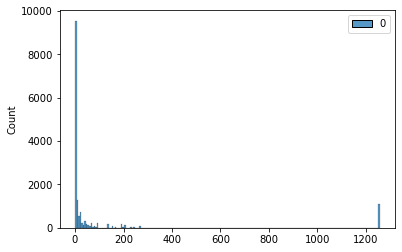

In [24]:
sns.histplot(linked_deposits_counts.values(), bins=200)

### From here on it is only some results exploration...

In [228]:
max(linked_deposits_counts)

1257

In [254]:
dict(filter(lambda elem: elem[1] == 1257, linked_deposits_counts.items()))

{'0xef0dd32645447a1607197d78aad9905721e0c287550e4196df354ac197c25f4a': 1257,
 '0xc0ef8c72e95e15d677a56ca4ecc33ba65f37a845aa4ce162f8e0efd6563db2a2': 1257,
 '0x1f85ee1fdd101f2e5a174636cda760693aa078466f83b0f1e19c766152738371': 1257,
 '0xbace5d33d2ce99ea408a03924846f4f5bc47b5125be367f24bbf4a036abbc53e': 1257,
 '0xb854bf5c8dc594b5006e4303048b86cec6eb54381bfbdc9aa0832c27a54220a6': 1257,
 '0x99b09453c62a24b9b7f78c27b37d1c06c2b9a64285412bf7e73609746a00abc0': 1257,
 '0x7d98413258082072cae8da9fd3409745573aa24c38e9551a0b8c38cf2b5ad66d': 1257,
 '0xc7ec2ae33e9e5710b27b999a04d56050c7e60ce9ba5c58097b20918f321bbfdd': 1257,
 '0xa0b96bec4615aad1d3c79871316cadd13f0b632e95ad4b5ec2235626e1aa36e3': 1257,
 '0x4a5d1ca63de0b2aafadf24d4b6f13bffee720750cfdd48740240022827587f0c': 1257,
 '0x192b1f3d6f6ae70742e524011177692f8336fe7251c2532208eef49041ff2e91': 1257,
 '0x3d0aaf7dec3f7553a6cd6920a57d5da827079a6807ef5414c5187c9e398bb757': 1257,
 '0x7eb5056a40a238908da5b2cb52ad2a909200ce2c1a639130ec542422b234c89c': 1257,

In [255]:
withdraw_txs[withdraw_txs["hash"] == "0x3eed548d17f9d5864cb45a4c15ee67657cd829098b3b0b78feb53200323a23d3"]


,Unnamed: 0,Unnamed: 0.1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,...,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address,recipient_address,tcash_pool
61285,61285,105921,0x3eed548d17f9d5864cb45a4c15ee67657cd829098b3b...,61,70,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0x905b63fff465b9ffbf41dea908ceb12478ec7601,0,554056,85000000000,...,2021-03-29 06:13:40 UTC,12132448,0x161ce244ac9513527c7653451dd2fdaf8f1eac5d59ba...,NaN,NaN,NaN,85000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0.1 ETH


In [256]:
waddr = "0xe472ac95d171b788c8184bb83c4927f0f043c0b0"
withdraw_txs[withdraw_txs["recipient_address"] == waddr]

,Unnamed: 0,Unnamed: 0.1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,...,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address,recipient_address,tcash_pool
23189,23189,4650,0x192b1f3d6f6ae70742e524011177692f8336fe7251c2...,28,78,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0x905b63fff465b9ffbf41dea908ceb12478ec7601,0,554056,85000000000,...,2021-03-28 13:22:32 UTC,12127859,0x0e1a0a3101aa604060afbd799f9c790b21a8758ce666...,NaN,NaN,NaN,85000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0.1 ETH
24046,24046,15937,0xed797df7cdd8fc2262deb444f905a6b45a3756d8e5c9...,109,111,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,564411,65000000000,...,2021-04-12 06:13:18 UTC,12223554,0xa27178b74b6401a4ee75d42b8d91fbea2f44d118de42...,NaN,NaN,NaN,65000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0.1 ETH
24048,24048,15939,0x0ee6d471ad8bb4217ed0e416e2c51af2d6e486e0f3fe...,143,73,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,560925,71500000000,...,2021-04-12 09:38:02 UTC,12224498,0x016b4fcef3951c31c344de02b1ebc65c7f019b3730f8...,NaN,NaN,NaN,71500000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0.1 ETH
24061,24061,15952,0xdfbc3ea629c6989b975ea6601c6884d47213599dc6ac...,144,90,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,560925,71500000000,...,2021-04-12 09:40:57 UTC,12224512,0x2be7f46599b73c060b014d139c5c6608fcdcc9e40a47...,NaN,NaN,NaN,71500000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0.1 ETH
25110,25110,20442,0x0995f71acae8e596d512be1add9eafbdd087be77b0c0...,43,100,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0x905b63fff465b9ffbf41dea908ceb12478ec7601,0,573217,85000000000,...,2021-03-29 02:22:45 UTC,12131405,0xebbf36368a1ce9df371b59fc3db75944180e0f3ec6ee...,NaN,NaN,NaN,85000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0.1 ETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65987,65987,130710,0xfa7fedaaee58c3a5aaa62509c78e3d590a94df36b31f...,531,160,0x28a51fd7b39b49ad4d7813d89e3d4444d79e3ac6,0x905b63fff465b9ffbf41dea908ceb12478ec7601,0,425273,140400000802,...,2021-03-26 13:54:15 UTC,12115002,0x5a1893cf076d9f6618b9fc3bcf33a450c6b1d933d992...,NaN,NaN,NaN,140400000802,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0.1 ETH
68814,68814,141333,0x4a8f1d7816bebeeb20fd776bd45ce6c7e2446a96a994...,44,38,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0x905b63fff465b9ffbf41dea908ceb12478ec7601,0,554020,85000000000,...,2021-03-29 02:22:47 UTC,12131406,0xb96d949278e2e1c6a9f08e9f7a6ed74afdaaa7ad823a...,NaN,NaN,NaN,85000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0.1 ETH
70752,70752,150187,0x2ca1e3f581cf4707be7936389237128ebbf285964b57...,45,58,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0x905b63fff465b9ffbf41dea908ceb12478ec7601,0,554032,85000000000,...,2021-03-29 02:24:19 UTC,12131413,0x12b9467f2e34fcf86abf08863cad1f629c78c856a384...,NaN,NaN,NaN,85000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0.1 ETH
72459,72459,158058,0xd1ef4105c11a08393a5db31563825a8b826ff4af761e...,141,139,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,560901,71500000000,...,2021-04-12 09:33:30 UTC,12224479,0xcb1896a5b3ce18aa8d56ec9d700ba3d75fcf95abaf58...,NaN,NaN,NaN,71500000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xe472ac95d171b788c8184bb83c4927f0f043c0b0,0.1 ETH


In [25]:
withdraw_txs.groupby("hash")["recipient_address"].apply(list)

hash
0x000045f6970d2b98c9c13f777e4c05c3310f6d604cc4b5a569f634aaaf589cde    [0x0214fe53ec07cf92807613006277684512cfc605]
0x0000576aa3946b7155a0c97e3c625785a4485ba34fe84485ccf349b9822873aa    [0xaecce96efbf383eae601b60f92721110de3df0b4]
0x00005ab45038b18cd88c2407829db1a083a5ff7e4aafd1c4362ed8f5a4647a8d    [0xce19d314a10ba291e7ab2e33fd9ecd2e699141a2]
0x0001b822a6dc36126768c7cea0e4ce1d300300e9e30cd0109f7a65421e125c9a    [0x32d291688239b1209bb843e9daf828f616ef9a6a]
0x00023ce573a9ef341452d41ed4a2ec3819565cd5fc281fa8b2d8a3254fb08e21    [0x0011e7e004f60a026e760e30f56d74bbb58eb49a]
                                                                                          ...                     
0xfffc2112cb1230c27f23381a2e99bce05b9ea4f374b92f4dc31eb8b2c92fdf40    [0xe7a784acb145bd8993e83d41adf43b7c7195e995]
0xfffca1863a19790c5a485ab9156cf6c0657302859c5b5b838d3fe1846bf3fe0f    [0x33e7fea4801fef3e39eef5e3fad20812c0c53296]
0xfffd7d57770d6d7c52ec01928e408d60a9bff03a74ed1acb3f7ad3524fb1acaa    [0x6c

In [262]:
w2addr

hash                 {0: '0x3dc8617176f45c0f33a95589c202b22f9ba8aa7...
recipient_address    {0: '0xd843ce0f9da3bd30537b9850711ab8089e06b4c...
dtype: object